# Lab 2: Clustering

## Mohamed Aymen QABEL
## Inès FLOREZ DE LA COLINA

The goal of this lab session is to code a clustering algorithm, apply it to data and compare the performance with other techniques.

You have to send the filled notebook named **"L2_familyname1_familyname2.ipynb"** (groups of 2) by email to aml.centralesupelec.2019@gmail.com by October 10, 2019. Please put **"AML-L2"** in the subject. 

We begin with the standard imports:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster # all clustering techniques except hdbscan
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

We will have two toy datasets to try the different methods:

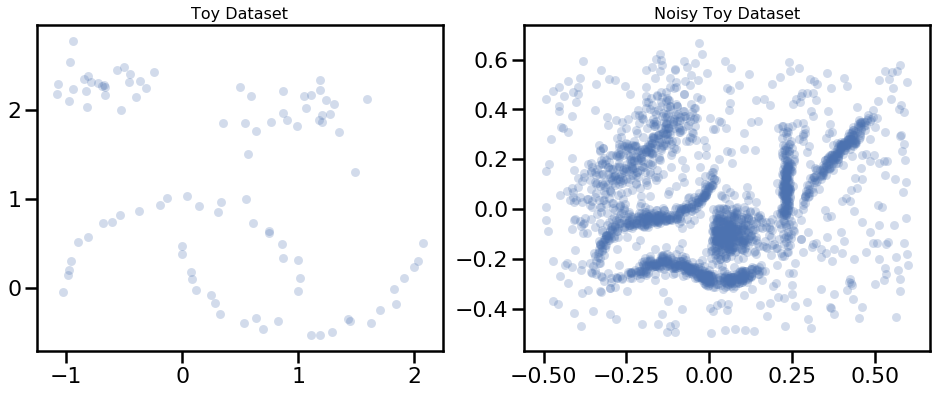

In [4]:
import sklearn.datasets as data
moons, _ = data.make_moons(n_samples=50, noise=0.05)
blobs, _ = data.make_blobs(n_samples=50, centers=[(-0.75,2.25), (1.0, 2.0)], cluster_std=0.25)
test_data_0 = np.vstack([moons, blobs])

test_data_1 = np.load('clusterable_data.npy')

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c='b', **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], color='b', **plot_kwds)
ax[1].set_title('Noisy Toy Dataset', size=16)

plt.show();

There are a lot of clustering algorithms to choose from the `sklearn` library. So what clustering algorithms should you be using? It depends.

## K-means

K-Means is the 'go-to' clustering algorithm for many simply because it is fast, easy to understand, and available everywhere (there's an implementation in almost any statistical or machine learning tool you care to use). However, K-Means has a few problems caused by its simplicity. 

We try the `sklearn` implementation in our toy datasets:

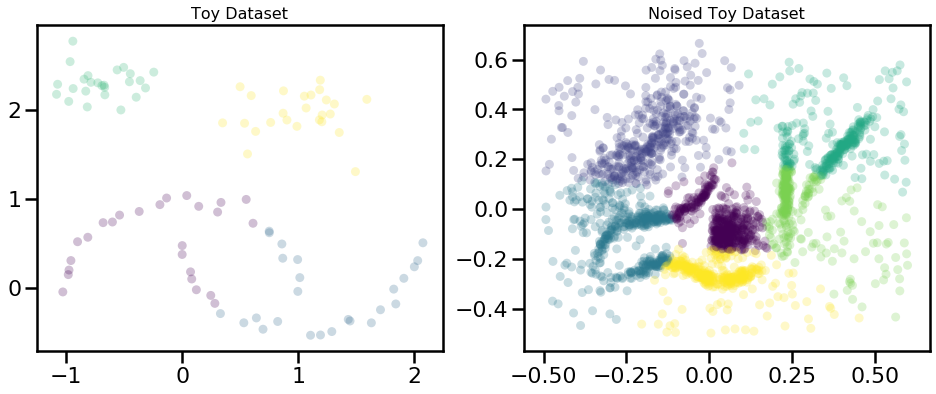

In [5]:
from sklearn.cluster import KMeans
kmeans_0 = KMeans(n_clusters=4, max_iter=200).fit(test_data_0)
kmeans_1 = KMeans(n_clusters=6, max_iter=200).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=kmeans_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=kmeans_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

## Aglomerative Single Linkage clustering

Agglomerative clustering is a suite of algorithms all based on the same idea. The fundamental idea is that you start with each point in it's own cluster and then, for each cluster, use some criterion to choose another cluster to merge with. Do this repeatedly until you have only one cluster and you get get a hierarchy, or binary tree, of clusters branching down to the last layer which has a leaf for each point in the dataset. The most basic version of this, single linkage, chooses the closest cluster to merge, and hence the tree can be ranked by distance as to when clusters merged/split.

**Code your own Aglomerative Single Linkage clustering algorithm**!:

- Fill in the class 
- During the process, keep track of the cluster merges by saving a (num_samples-1,4) np.array being a linkage matrix in scypy format (to use their function to plot dendrogram: `scipy.cluster.hierarchy.dendrogram`). check documentation.

In [6]:
class my_SingleLinkageAglomerativeClustering():
    
    def __init__(self, metric="euclidean", n_clusters=3):
        '''
        Attributes:
        
        metric_: {"euclidean","precomputed"}
            the distance to be used
            if precomputed then X is distance matrix
        n_clusters: integer
            number of clusters to return 
        linkage_matrix_: (n-1, 4) np.array
            in the same format as linkage  
        labels_: integer np.array
            label assigment
        hierarchy_: list of np.array
            each array corresponds to label assigment
            at each level (number of clusters)
            hierarchy_[0]=np.array(list(range(n)))
        '''
        self.metric_ = metric
        self.n_clusters_ = n_clusters
        self.linkage_matrix_ = None
        self.labels_ = None
        self.hierarchy_ = None
        self.distance_ = []
        
    def fit(self, X):
        """ Create a hierarchy of clusters
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self: my_SingleLinkageAglomerativeClustering
            to have access to labels_
        """
        # initialization of all parameters
        n, p = np.shape(X)
        self_labels_ = np.array([[],[],[]])
        self.linkage_matrix_ = np.zeros((n-1,4))
        indices = np.array([1 for i in range(n)]) #used to get the right node number for the linkage matrix
        
        # If it is not precomputed then compute the distance matrix        
        if self.metric_ == "euclidean":
            init_dist = np.zeros((n,n))
            for i in range(n):
                for j in range(n):
                    if i == j:
                        init_dist[i][j] = math.inf  #initialize the distance matrix to infinity for the distance between x and 
                                                    # itself so that it doesn't cause problems for the minimum
                    else:
                        dist = distance.euclidean(X[i],X[j])
                        init_dist[i][j] = dist
        
        # Get the linkage matrix by modifying the distance matrix matrix
        num_clust = n
        label = 0
        cpt = 0
        prev = np.zeros((1,n))
        segments = [[i for i in range(n)]] #used to compute the hierarchy matrix
        
        #Agglomerative clustering
        while num_clust > 1:
            
            n_dist, p_dist = np.shape(init_dist)
            
            #get the distance between the two nearest clusters for merge
            mini = init_dist.min() 
            index = np.where(init_dist == mini)
            i,j = index[0][0], index[1][0]
            self.distance_.append(mini)
            
            #get the parameters of the new node created
            new_node = indices[i] + indices[j]
            indices = np.hstack((indices, np.array([new_node])))
            new_row = []
            
            #update the rows and columns of the distance matrix by adding a row and column corresponding
            #to the new node and setting rows/columns i, j to inf (already dealt with those points)
            for l in range(p_dist):   
                if l != i and l != j:
                    mini_i = init_dist[i][l]
                    mini_j = init_dist[j][l]
                    new_row.append(min(mini_i, mini_j))
                else:
                    new_row.append(math.inf)
            self.linkage_matrix_[label] = [i, j, mini, new_node]
            init_dist[i] = [math.inf for i in range(p_dist)]  # update the rows and columns corresponding to i and j to inf 
            init_dist[j] = [math.inf for i in range(p_dist)]  # to show that there are used points
            init_dist[:,i] = [math.inf for i in range(n_dist)]
            init_dist[:,j] = [math.inf for i in range(n_dist)] 
            init_dist = np.vstack((init_dist, np.array(new_row)))
            new_row.append(math.inf)
            init_dist = np.hstack((init_dist, np.atleast_2d(np.array(new_row)).T))
            
            #update the segments liste to be used afterwards to get the hierarchy matrix
            prev = np.array(segments[cpt])
            point_1 = np.where(prev == i)[0]
            point_2 = np.where(prev == j)[0]
            for l in point_1:
                prev[point_1] = n + cpt
            for l in point_2:
                prev[point_2] = n + cpt
            segments.append(prev)
            
            #update the counters
            num_clust -= 1       
            label += 1 
            cpt += 1
        
        #updating the hierarchy matrix
        segments[0] = np.array(segments[0])
        #segments.append(np.array([cpt + n for i in range(n)]))
        self.hierarchy_ = segments
        
        #updating the labels matrix
        self.labels_ = self.hierarchy_[n-self.n_clusters_]
        mini_labels = min(self.labels_)
        maxi_labels = max(self.labels_)
        # print(self.hierarchy_)
        
        #set the labels of the clusters to 0, 1, ..., n_clusters - 1
        num_clust = 0
        dict_clust = {}
        for i in self.labels_:
            if i not in dict_clust:
                dict_clust[i] = num_clust
                num_clust += 1
        for i in range(len(self.labels_)):
            self.labels_[i] = dict_clust[self.labels_[i]]
        #print(self.labels_)
        #print(self.hierarchy_)

       
    def plot_dendrogram(self):
        '''Use self.linkage_matrix_ in `scipy.cluster.hierarchy.dendrogram` 
        to plot the dendrogram of the hierarchical structure
        '''        
        self.fit(X)
        fig = plt.figure(figsize=(25, 10))
        dn = dendrogram(self.linkage_matrix_)
        plt.show()
        fig = plt.figure(figsize=(25, 10))
        plt.title('Plotting the minimum distance at every iteration')
        plt.plot(self.distance_)
        return self.labels_

Apply the method to our toy datasets

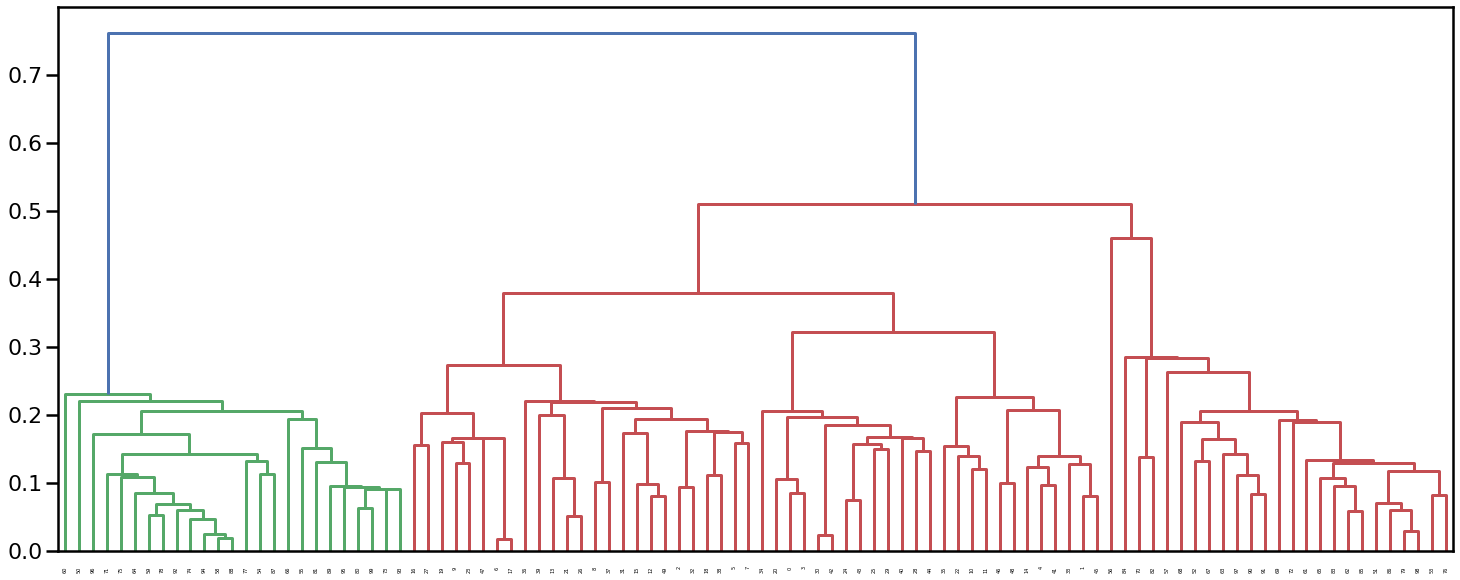

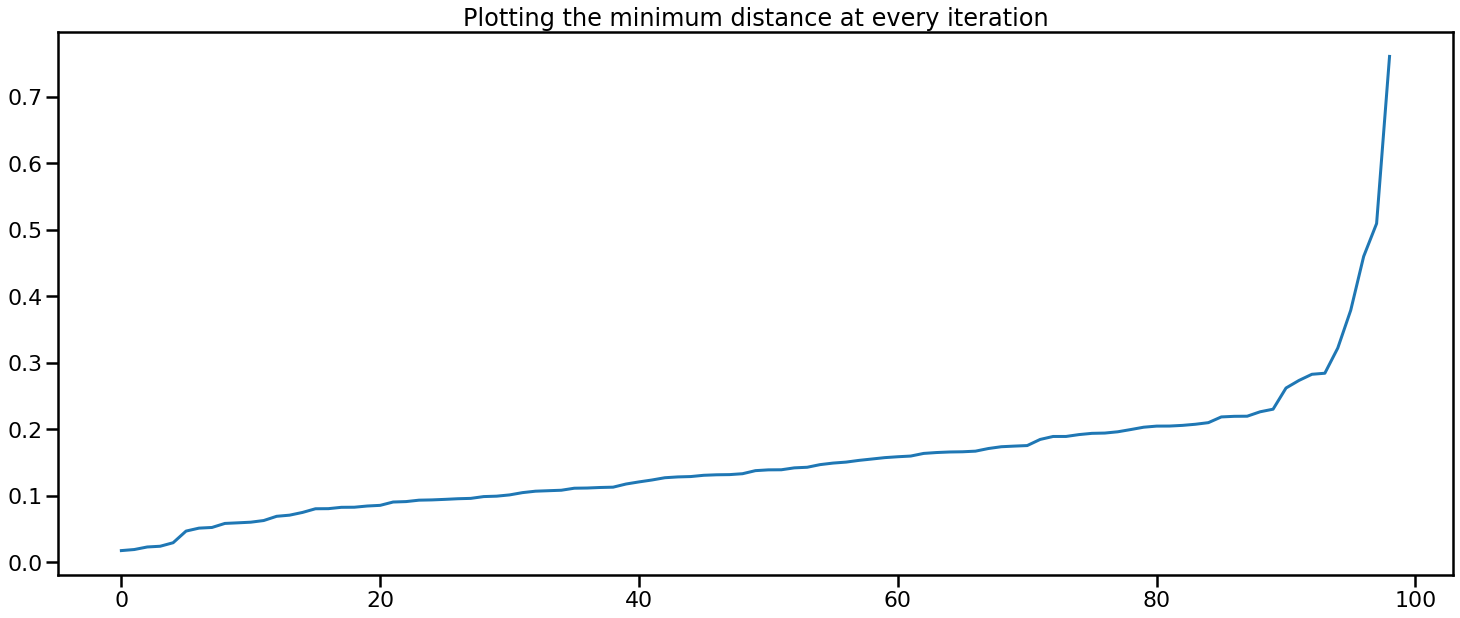

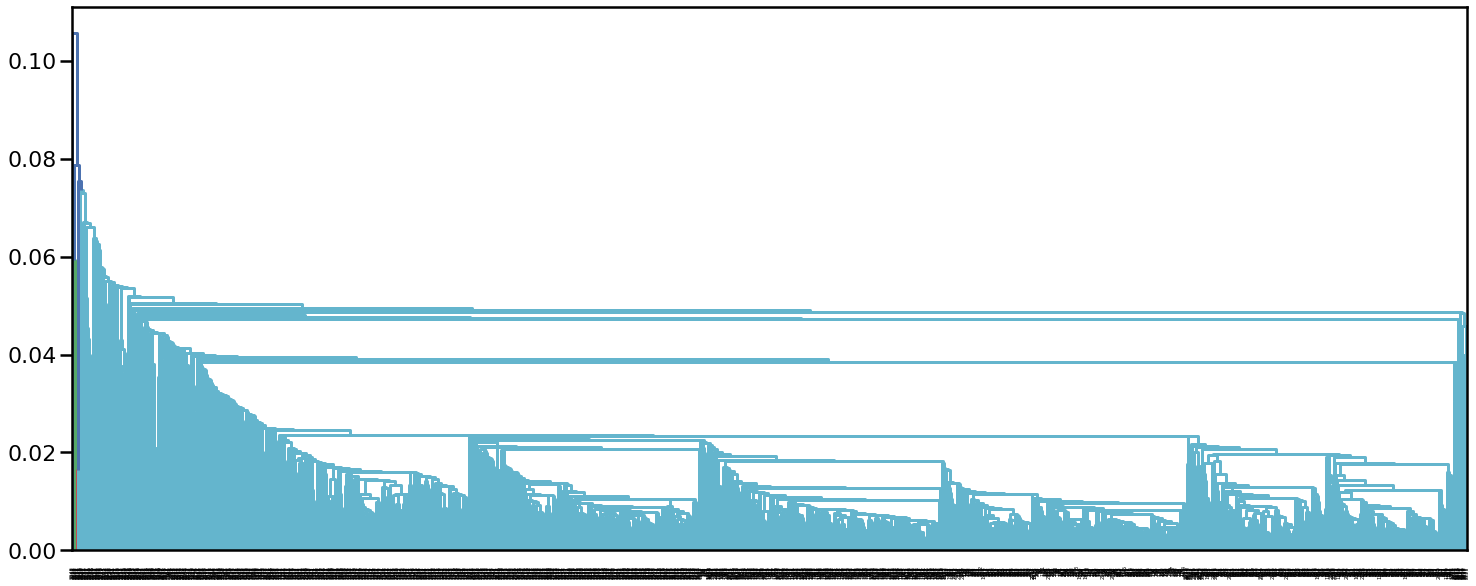

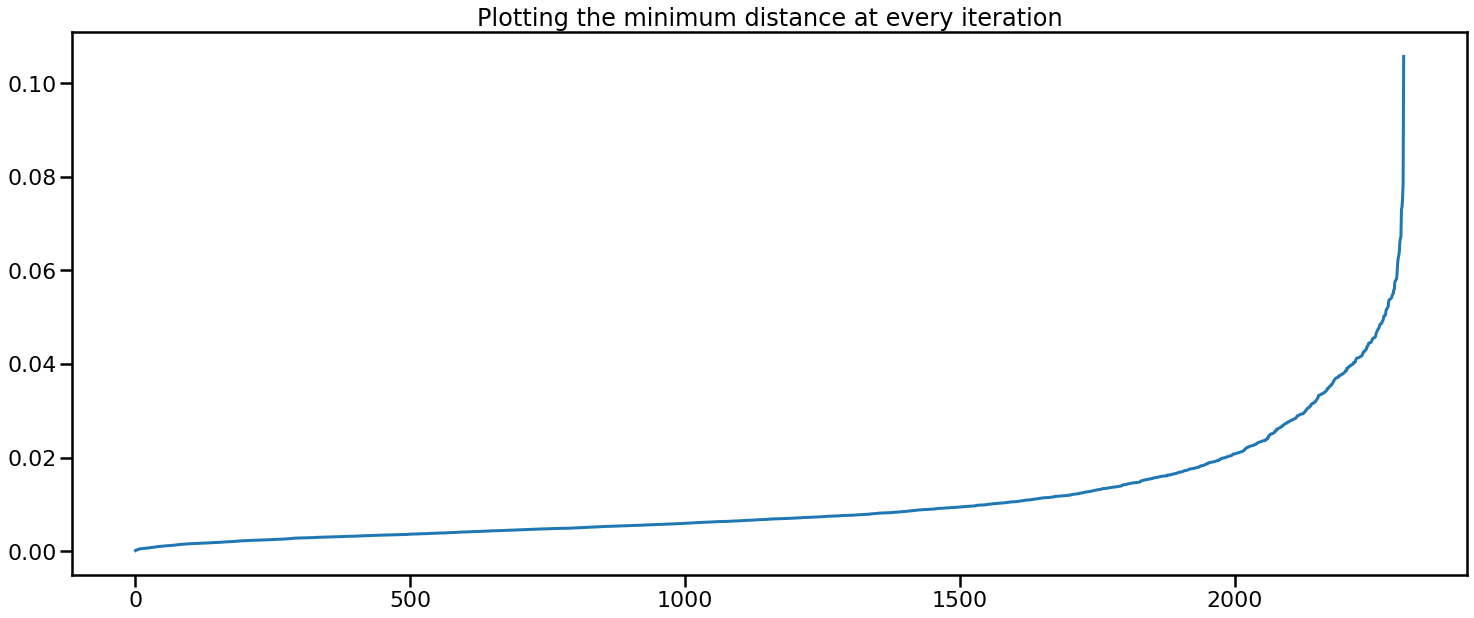

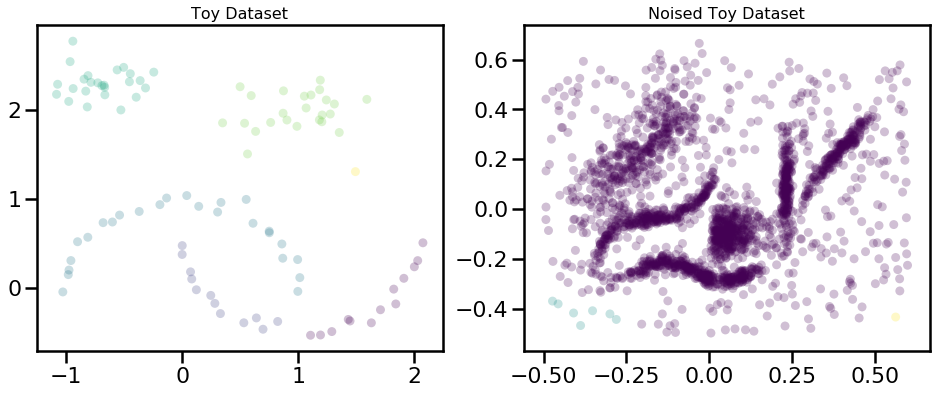

In [7]:
from scipy.spatial import distance 
from scipy.cluster.hierarchy import dendrogram
import math

# TODO

X = test_data_0
agg_lab_0 = my_SingleLinkageAglomerativeClustering(n_clusters = 6).plot_dendrogram()

X = test_data_1
agg_lab_1 = my_SingleLinkageAglomerativeClustering().plot_dendrogram()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=agg_lab_0, **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=agg_lab_1, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)

plt.show();

Try the different linkage methods implemented in `sklearn`  and comment

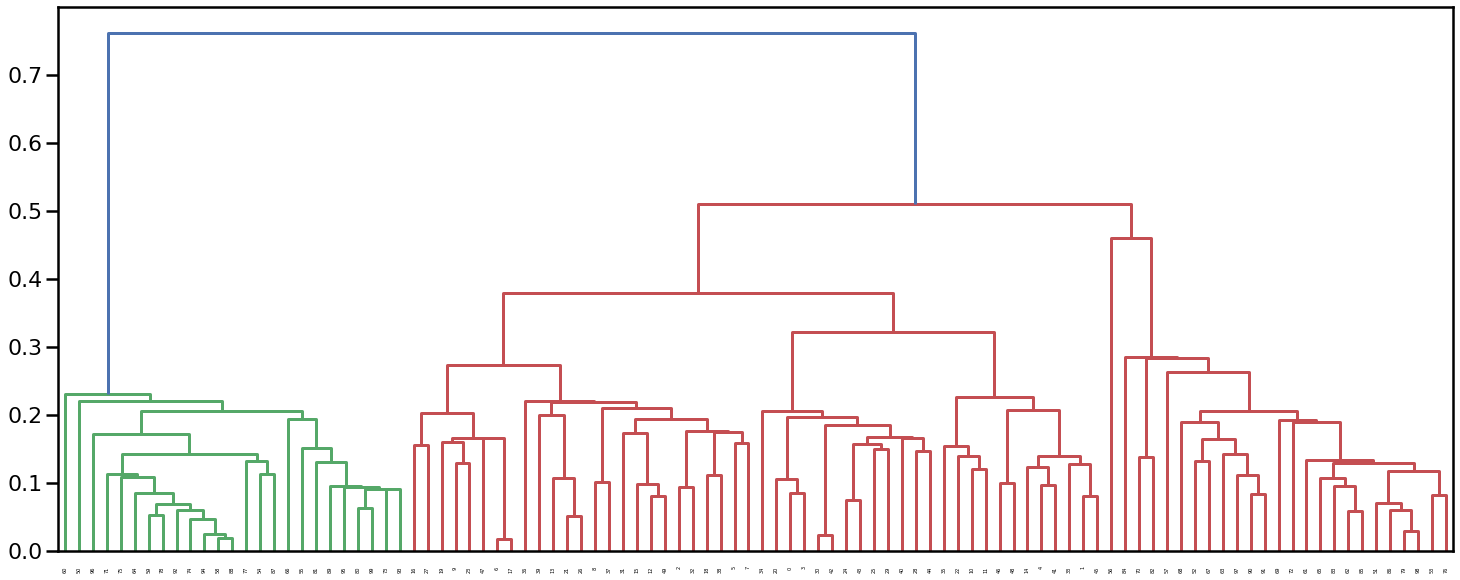

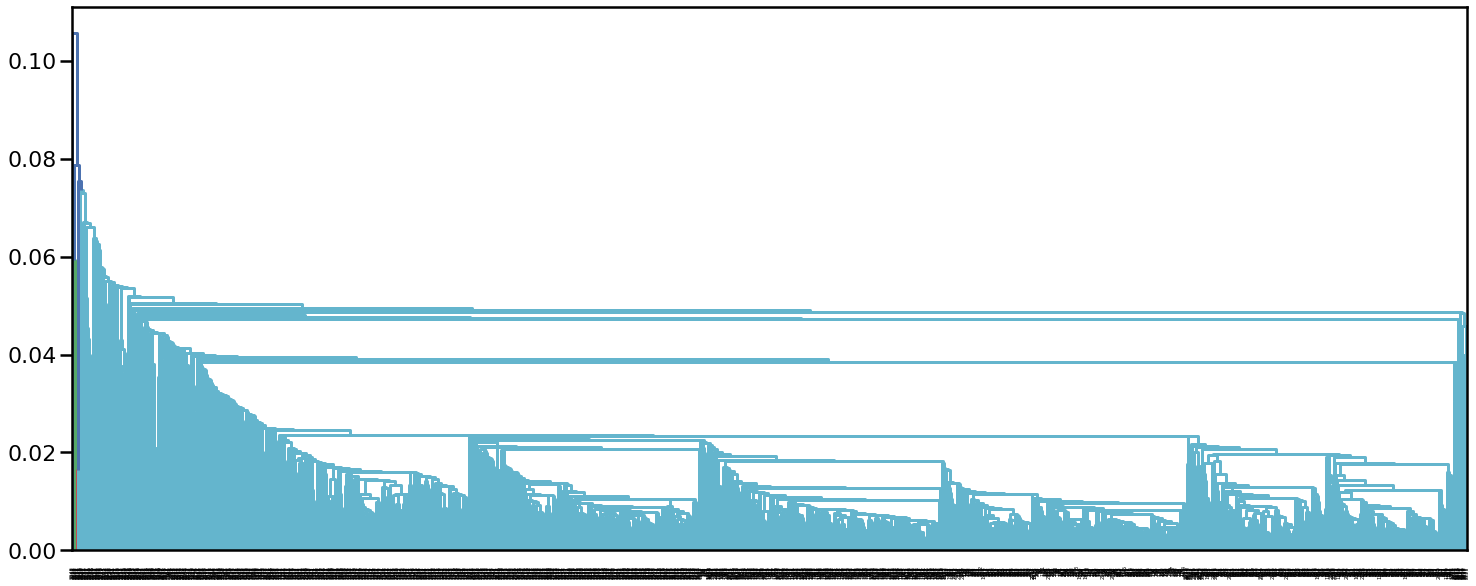

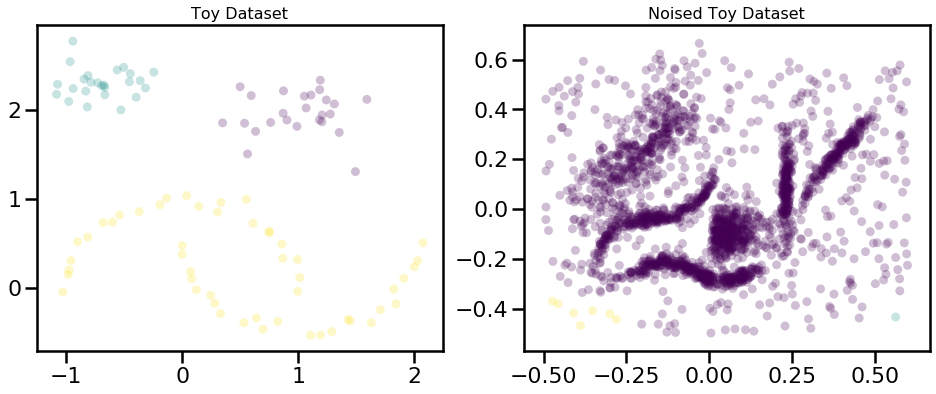

In [9]:
# TODO
from scipy.cluster.hierarchy import linkage
Z_0 = linkage(test_data_0, 'single')
Z_1 = linkage(test_data_1, 'single')#printé pour 10 échantillons pour que ce soit plus clair pour toi


fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z_0)
plt.show()

fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z_1)
plt.show()

from sklearn.cluster import AgglomerativeClustering
agg_clust_0 = AgglomerativeClustering(n_clusters=3, linkage = "single").fit(test_data_0)
agg_clust_1 = AgglomerativeClustering(n_clusters=3, linkage = "single").fit(test_data_1)
# print(agg_clust_1.labels_)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c= agg_clust_0.labels_, **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c= agg_clust_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

On remarque qu'on a les même résultats qu'avec l'algorithme de scipy.

## DBSCAN

DBSCAN is a density based algorithm -- it assumes clusters for dense regions. It is also the first actual clustering algorithm we've looked at: it doesn't require that every point be assigned to a cluster and hence doesn't partition the data, but instead extracts the 'dense' clusters and leaves sparse background classified as 'noise'. In practice DBSCAN is related to agglomerative clustering. As a first step DBSCAN transforms the space according to the density of the data: points in dense regions are left alone, while points in sparse regions are moved further away. Applying single linkage clustering to the transformed space results in a dendrogram, which we cut according to a distance parameter (called epsilon or `eps` in many implementations) to get clusters. Importantly any singleton clusters at that cut level are deemed to be 'noise' and left unclustered. 

Apply it to the test_data, how do you tune the parameters?

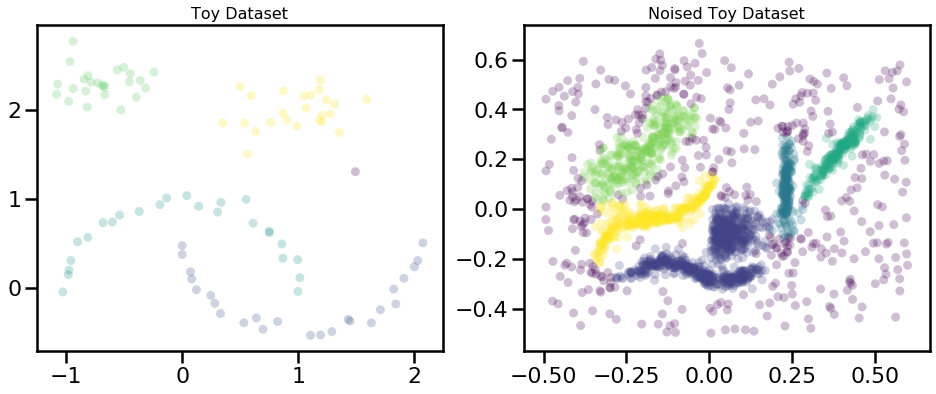

In [10]:
# TODO
from sklearn.cluster import DBSCAN


dbscan_0 = DBSCAN(eps=0.35, min_samples=3).fit(test_data_0)
dbscan_1 = DBSCAN(eps=0.04, min_samples=19).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=dbscan_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=dbscan_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)


plt.show();

## HDBSCAN

HDBSCAN is a recent algorithm developed by some of the same people who write the original DBSCAN paper. Their goal was to allow varying density clusters. The algorithm starts off much the same as DBSCAN: we transform the space according to density, exactly as DBSCAN does, and perform single linkage clustering on the transformed space. Instead of taking an epsilon value as a cut level for the dendrogram however, a different approach is taken: the dendrogram is condensed by viewing splits that result in a small number of points splitting off as points 'falling out of a cluster'. This results in a smaller tree with fewer clusters that 'lose points'. That tree can then be used to select the most stable or persistent clusters. This process allows the tree to be cut at varying height, picking our varying density clusters based on cluster stability.

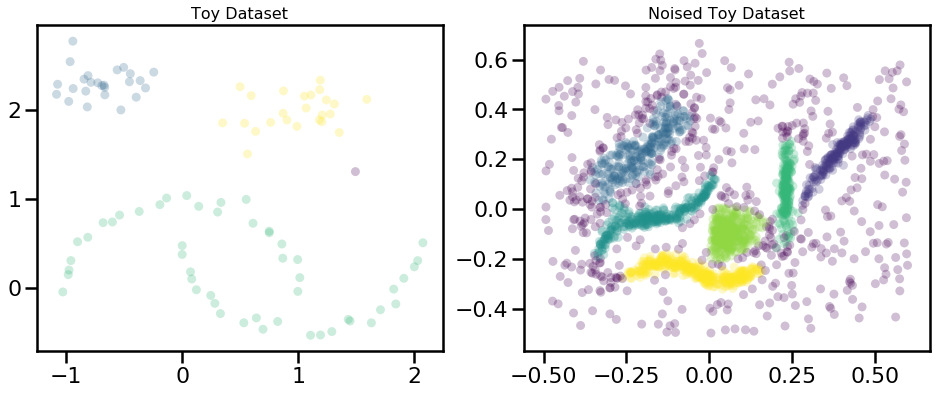

In [11]:
import hdbscan
from hdbscan import HDBSCAN

# TODO
hdbscan_0 = HDBSCAN(min_cluster_size=3).fit(test_data_0)
hdbscan_1 = HDBSCAN(min_cluster_size=15).fit(test_data_1)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].scatter(test_data_0.T[0], test_data_0.T[1], c=hdbscan_0.labels_ , **plot_kwds)
ax[0].set_title('Toy Dataset', size=16)

ax[1].scatter(test_data_1.T[0], test_data_1.T[1], c=hdbscan_1.labels_, **plot_kwds)
ax[1].set_title('Noised Toy Dataset', size=16)



plt.show();

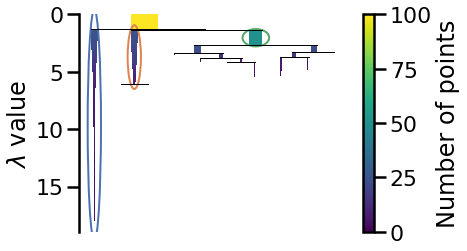

In [86]:
hdbscan_0.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))

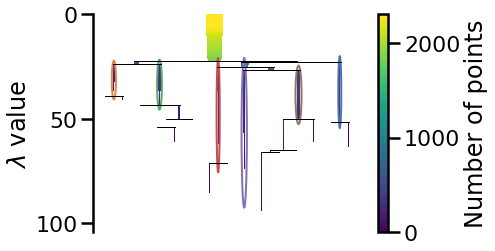

In [85]:
hdbscan_1.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))

## Apply the algorithms to the following images and comment the results

### NASA Curiosity Picture

- Look at following NASA photo taken by a robot in mars:


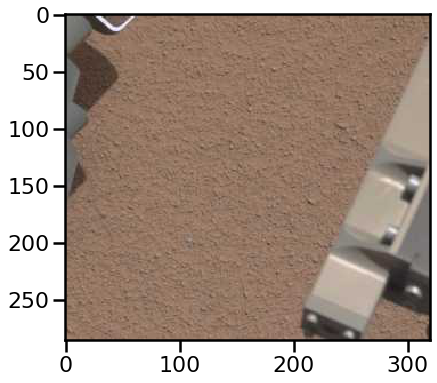

In [7]:
from PIL import Image

Im_1  = Image.open('im_nasa_reduced-1.jpg')

fig = plt.figure(figsize=(8, 6))
plt.imshow(Im_1)
plt.show()

- Transform the image to an intensity (I) and saturation (S) representation, it helps to distinguish bright and textures.

$$I=\frac{R+G+B}{3}$$
$$S=1-I\times min(R, G, B)$$

In [93]:
# TODO:
from PIL import ImageColor
(largeur, hauteur)= Im_1.size
Int = np.zeros((largeur, hauteur))
Sat= np.zeros((largeur, hauteur))
X = []
for i in range(hauteur):
    for j in range(largeur):
        R,G,B = Im_1.getpixel((j,i))
        I = (R+G+B)/3
        S = 1-I*min(R,G,B)
        Int[j][i] = I
        Sat[j][i] = S    
        X.append([I,S])


- Apply the seen algorithms to segment the image in the Intensity-Saturation representation, comment the results and check if you find something on mars' surface. Be careful with hdbscan and memory errors for some parameters choice (use algorithm='boruvka_kdtree').

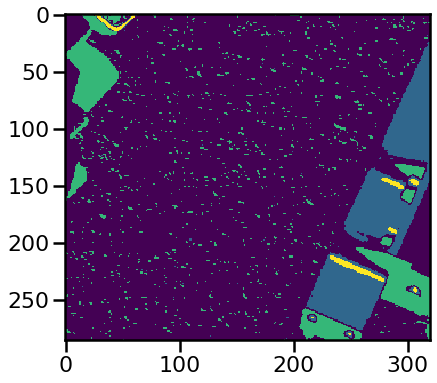

In [89]:
#Kmeans:
kmeans= KMeans(n_clusters=4, max_iter=1000).fit(X)
img = kmeans.labels_
img = img.reshape((hauteur, largeur))

fig = plt.figure(figsize=(8, 6))
plt.imshow(img)



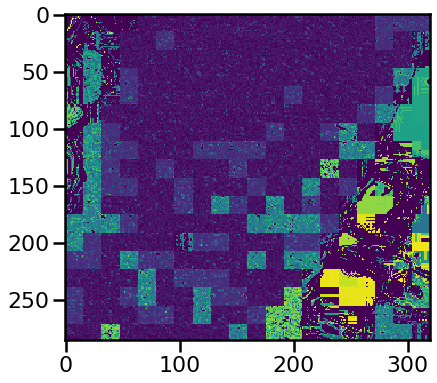

In [464]:
#DBSCAN :
dbscan = DBSCAN(eps=5, min_samples=20).fit(X)
img = dbscan.labels_
img = img.reshape((hauteur, largeur))

fig = plt.figure(figsize=(8, 6))
plt.imshow(img)


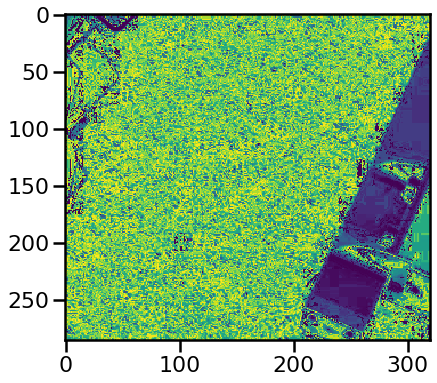

In [435]:
#HDBSCAN :
hdbscan = HDBSCAN(min_cluster_size=30,min_samples=15).fit(X)
img = hdbscan.labels_
img = img.reshape((hauteur, largeur))

fig = plt.figure(figsize=(8, 6))
plt.imshow(img)


### Color compression

One interesting application of clustering is in color compression within images. 
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

Get a simplified 10-colored version of the following image by applying k-means. Plot both images.

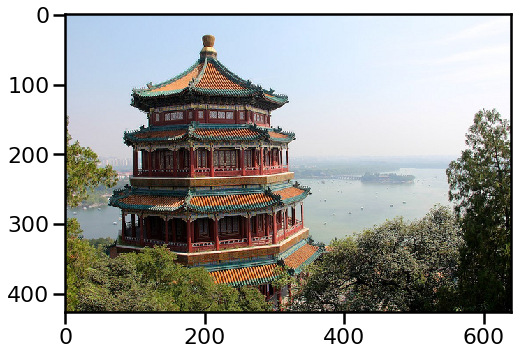

In [470]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")

fig = plt.figure(figsize=(8, 6))
plt.imshow(china);

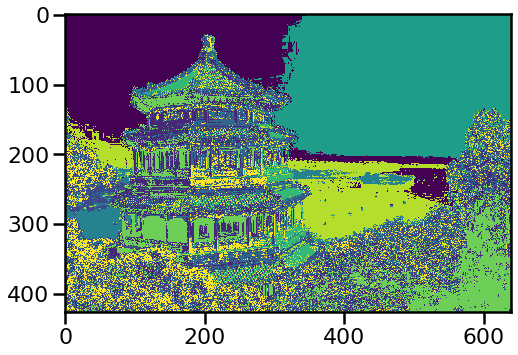

In [479]:
# TODO
#reshape the image into a 2Dimensional array : 
china_ = china.reshape((-1,3))
hauteur, largeur = china.shape[0], china.shape[1]
kmeans= KMeans(n_clusters=10, max_iter=200).fit(china_)
img = kmeans.labels_
img = img.reshape((hauteur, largeur))

fig = plt.figure(figsize=(8, 6))
plt.imshow(img)